In [1]:
from Functions import models
nn_params = models.NeuralNetworkParams()

nn_model = models.NeuralNetworkModel()
help(nn_model)

/home/natmourajr/.virtualenvs/petro_cessy/lib/python2.7/site-packages/scipy/sparse/lil.py:19: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _csparsetools
/home/natmourajr/.virtualenvs/petro_cessy/lib/python2.7/site-packages/scipy/sparse/csgraph/__init__.py:165: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._shortest_path import shortest_path, floyd_warshall, dijkstra,\
/home/natmourajr/.virtualenvs/petro_cessy/lib/python2.7/site-packages/scipy/sparse/csgraph/_validation.py:5: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._tools import csgraph_to_dense, csgraph_from_dense,\
/home/natmourajr/.virtualenvs/petro_cessy/lib/python2.7/site-packages/scipy/sparse/csgraph/__init__.py:167: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._traversal imp

Help on NeuralNetworkModel in module Functions.models object:

class NeuralNetworkModel(Base)
 |  Neural Network Model Class
 |  
 |  Method resolution order:
 |      NeuralNetworkModel
 |      Base
 |      __builtin__.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, verbose=False)
 |  
 |  __repr__(self)
 |  
 |  __str__(self)
 |  
 |  fit(self, inputs, outputs, train_indexes, n_neurons=2, activation_functions=['tanh', 'softmax'], trn_params=None)
 |      Neural Network Fit Function
 |      
 |      inputs: normalized input matrix (events X features)
 |      output: categarical (max sparse) output matrix (events X classes)
 |      n_neurons: integer 
 |      activation_functions: 
 |      trn_params: training parameters (NeuralNetworkParams obj)
 |  
 |  get_str(self)
 |  
 |  load(self, filename, path='.')
 |      Neural Network Load Function
 |      
 |      filename: basic file name all files will contend it
 |      path: where to store this files
 |  
 |  predict(self

In [40]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.externals import joblib

import os

from Functions import models

iris = datasets.load_iris()

inputs = iris.data  
outputs = iris.target

#print inputs.shape
#print outputs.shape


n_folds = 2

folds_filename =  '../Results/StratifiedKFolds_%i_folds.jbl'%(n_folds)

if not os.path.isfile(folds_filename):
    skf = StratifiedKFold(n_splits=n_folds)
    skf.get_n_splits(inputs, outputs)
    joblib.dump(skf, folds_filename)
else:
    skf = joblib.load(folds_filename)

cat_outputs = -np.ones([outputs.shape[0],len(np.unique(outputs))])
for i,j in enumerate(outputs):
    cat_outputs[i,j] = 1

nn_models = {}

nn_params = models.NeuralNetworkParams(learning_rate=0.1,n_epochs=200,batch_size=16,verbose=True, n_inits=4)

n_neurons = 9

for ifold, [train_index, test_index] in enumerate(skf.split(inputs, outputs)):
    #if ifold > 0:        
    #    continue
    #normalize data
    scaler = preprocessing.StandardScaler().fit(inputs[train_index,:])
    normalized_inputs = scaler.transform(inputs)
    
    nn_models[ifold] = models.NeuralNetworkModel()
    nn_models[ifold].loss = 'categorical_crossentropy'
    nn_models[ifold].optimizer = 'sgd'
    
    nn_models[ifold].fit(inputs=normalized_inputs, 
                         outputs=cat_outputs,
                         train_indexes=[train_index, test_index],
                         n_neurons=n_neurons, trn_params=nn_params, 
                         activation_functions=['relu', 'softmax'])
    nn_models[ifold].save('%s_%i_neurons_%i_fold'%(nn_models[ifold].get_str(), 
                                                   n_neurons,ifold),
                          '../Results/NeuralNetwork')

Neural Network Model - train 1 initialization
min loss: 9999.00000, model loss: 0.69649
Neural Network Model - train 2 initialization
min loss: 0.69649, model loss: 0.69403
Neural Network Model - train 3 initialization
Neural Network Model - train 4 initialization
Neural Network Model - train 1 initialization
min loss: 9999.00000, model loss: 0.72528
Neural Network Model - train 2 initialization
min loss: 0.72528, model loss: 0.72407
Neural Network Model - train 3 initialization
min loss: 0.72407, model loss: 0.72012
Neural Network Model - train 4 initialization


In [41]:
import os
import numpy as np
from Functions import models

from sklearn import datasets
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.externals import joblib

iris = datasets.load_iris()

inputs = iris.data  
outputs = iris.target
cat_outputs = -np.ones([outputs.shape[0],len(np.unique(outputs))])

nn_params = models.NeuralNetworkParams(learning_rate=0.01,n_epochs=200,batch_size=16,verbose=True, n_inits=4)
n_neurons = 9

n_folds = 2
folds_filename =  '../Results/StratifiedKFolds_%i_folds.jbl'%(n_folds)

if os.path.isfile(folds_filename):
    skf = joblib.load(folds_filename)
    for i,j in enumerate(outputs):
        cat_outputs[i,j] = 1
    cat_outputs = -np.ones([outputs.shape[0],len(np.unique(outputs))])

    nn_test_models = {}
    for ifold, [train_index, test_index] in enumerate(skf.split(inputs, outputs)):
        scaler = preprocessing.StandardScaler().fit(inputs[train_index,:])
        normalized_inputs = scaler.transform(inputs)
        
        nn_test_models[ifold] = models.NeuralNetworkModel()
        nn_test_models[ifold].loss = 'categorical_crossentropy'
        nn_test_models[ifold].optimizer = 'sgd'
    
        nn_test_models[ifold].load('%s_%i_neurons_%i_fold'%(nn_models[ifold].get_str(),n_neurons,ifold),'../Results/NeuralNetwork')
else:
    print "No trained model"

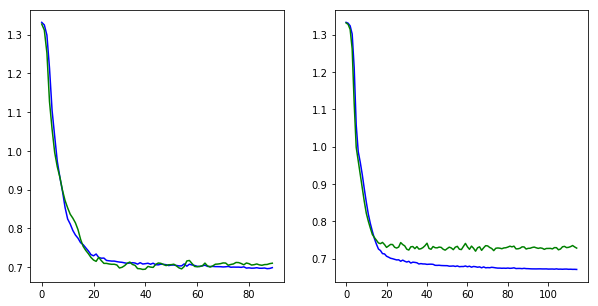

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

n_folds = 2

fig = plt.figure(figsize=(10,5))
nrows = 1
ncols = 2
for ifold in range(n_folds):
    ax = plt.subplot(nrows,ncols,ifold+1)
    epochs = range(len(nn_test_models[ifold].trn_desc[0]['acc']))
    ax.plot(epochs,nn_test_models[ifold].trn_desc[0]['loss'],'b')
    ax.plot(epochs,nn_test_models[ifold].trn_desc[0]['val_loss'],'g')